In [5]:
import pandas as pd
import numpy as np
import joblib

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

In [6]:
X_train = joblib.load('../../preprocessed_data/InSDN/X_train.joblib')
X_test = joblib.load('../../preprocessed_data/InSDN/X_test.joblib')
Y_train = joblib.load('../../preprocessed_data/InSDN/Y_train.joblib')
Y_test = joblib.load('../../preprocessed_data/InSDN/Y_test.joblib')

### CNN training

In [7]:
CNN_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2), # keep the maximum each 2 values (divide by 2 the number of values)
    Dropout(0.5), # disable 30% of neurons => reduce overfitting
    Flatten(), # transform the structure from 3D to 2D
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # binary output (0=normal or 1=attack)
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

CNN_model.summary()

history = CNN_model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_test, Y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 65, 32)            128       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 32, 32)            0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 32, 32)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

### LSTM training

In [4]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()


history = LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3


2025-06-17 14:43:02.128815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64513496 exceeds 10% of free system memory.


3762/3762 [==============================] - 74s 19ms/step - loss: 0.0365 - accuracy: 0.9907 - val_loss: 0.0129 - val_accuracy: 0.9969
Epoch 2/3
3762/3762 [==============================] - 71s 19ms/step - loss: 0.0203 - accuracy: 0.9957 - val_loss: 0.0152 - val_accuracy: 0.9965
Epoch 3/3
3762/3762 [==============================] - 71s 19ms/step - loss: 0.0153 - accuracy: 0.9967 - val_loss: 0.0152 - val_accuracy: 0.9970


### AE-LSTM

In [ ]:
input_dim = X_train.shape[1]  # n_features

# encoder (will shrink the input data making it more compact from 64 to 32 features)
inputs = Input(shape=(input_dim, 1))
encoded = LSTM(64, return_sequences=False)(inputs)
encoded = Dense(32, activation='relu')(encoded)

# classifier
x = Dropout(0.3)(encoded)
x = Dense(64, activation='relu')(x) # decode the input 64 features again
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

AE_LSTM_model = Model(inputs, output)

AE_LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
AE_LSTM_model.summary()


history = AE_LSTM_model.fit(X_train, Y_train, epochs=3, batch_size=64, validation_data=(X_test, Y_test)
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 67, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65    

2025-06-17 14:46:38.442478: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64513496 exceeds 10% of free system memory.


3762/3762 [==============================] - 72s 19ms/step - loss: 0.0358 - accuracy: 0.9908 - val_loss: 0.0183 - val_accuracy: 0.9963
Epoch 2/3
3762/3762 [==============================] - 74s 20ms/step - loss: 0.0190 - accuracy: 0.9960 - val_loss: 0.0203 - val_accuracy: 0.9953
Epoch 3/3
3762/3762 [==============================] - 73s 19ms/step - loss: 0.0150 - accuracy: 0.9967 - val_loss: 0.0130 - val_accuracy: 0.9972


Let's save our models

In [6]:
CNN_model.save("../../models/cnn_insdn_model.keras")
LSTM_model.save("../../models/lstm_insdn_model.keras")
AE_LSTM_model.save("../../models/ae-lstm_insdn_model.keras")

### CNN metrics

1283/1283 [==============================] - 1s 619us/step
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20528
     Attacks       0.99      1.00      0.99     20527

    accuracy                           0.99     41055
   macro avg       0.99      0.99      0.99     41055
weighted avg       0.99      0.99      0.99     41055

Test Loss: 0.0180
Test Accuracy: 0.9930


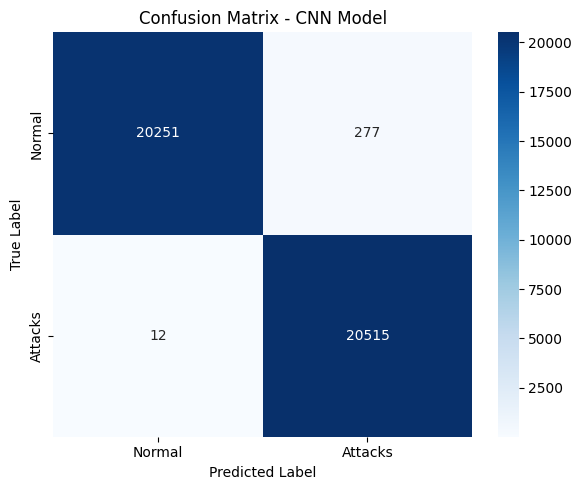

Attacks detected (True Positive) : 20515
Normal traffic detected (True Negative) : 20251
Attacks missed (False Negative) : 12
False alarms (False Positive) : 277


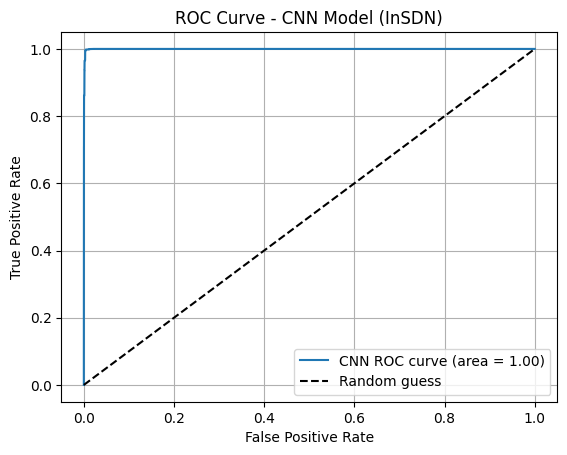

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = CNN_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/CNN_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'CNN ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/CNN_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### LSTM metrics

3224/3224 [==============================] - 15s 5ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20632
     Attacks       1.00      1.00      1.00     82535

    accuracy                           1.00    103167
   macro avg       1.00      0.99      1.00    103167
weighted avg       1.00      1.00      1.00    103167

Test Loss: 0.0152
Test Accuracy: 0.9970


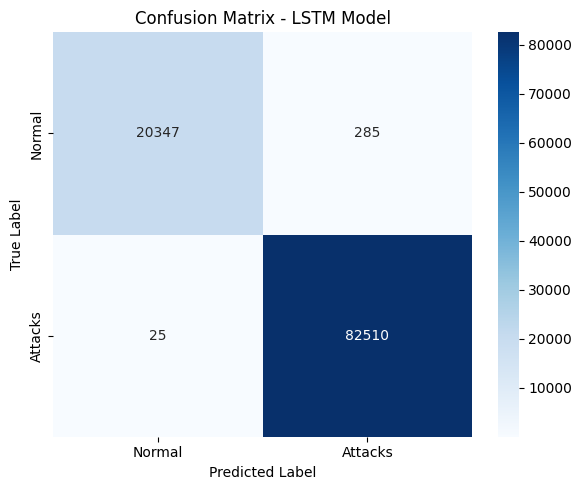

Attacks detected (True Positive) : 82510
Normal traffic detected (True Negative) : 20347
Attacks missed (False Negative) : 25
False alarms (False Positive) : 285


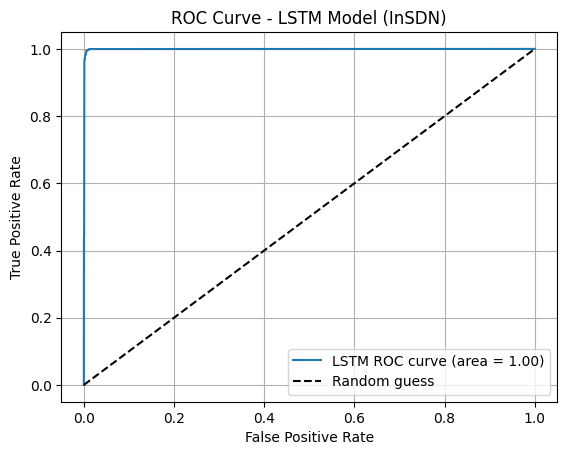

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


### AE-LSTM metrics

3224/3224 [==============================] - 15s 5ms/step
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     20632
     Attacks       1.00      1.00      1.00     82535

    accuracy                           1.00    103167
   macro avg       1.00      0.99      1.00    103167
weighted avg       1.00      1.00      1.00    103167

Test Loss: 0.0130
Test Accuracy: 0.9972


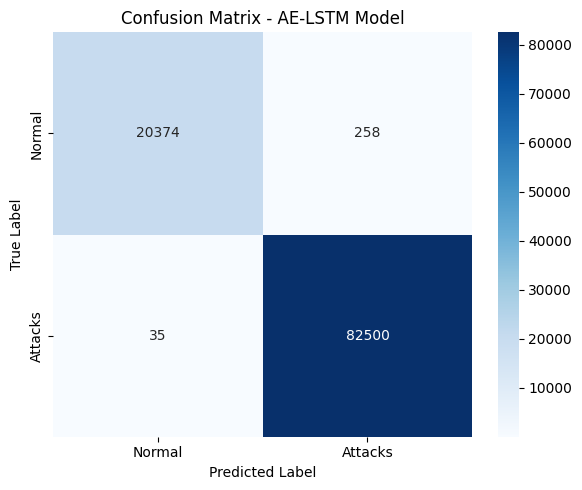

Attacks detected (True Positive) : 82500
Normal traffic detected (True Negative) : 20374
Attacks missed (False Negative) : 35
False alarms (False Positive) : 258


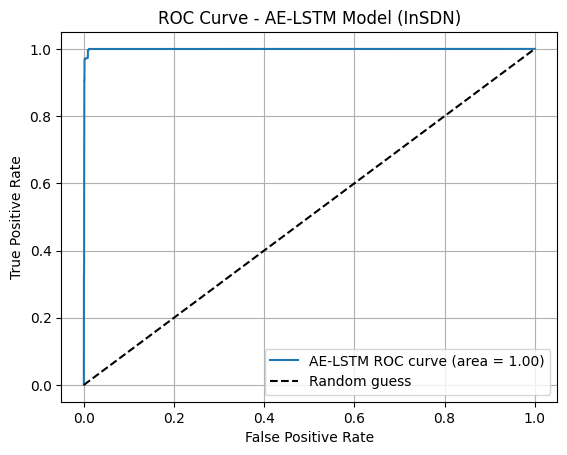

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = AE_LSTM_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, labels=[0,1], target_names=["Normal", "Attacks"]))

# Accuracy and loss
loss, accuracy = AE_LSTM_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# confusion Matrix
cm = confusion_matrix(Y_test, y_pred, labels=[0,1],)
labels = ["Normal", "Attacks"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - AE-LSTM Model')
plt.tight_layout()
plt.savefig("../../results/InSDN/AE-LSTM_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AE-LSTM ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AE-LSTM Model (InSDN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../../results/InSDN/AE-LSTM_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
import pickle

In [17]:
file_name_cnn = '../../models/cnn_InSDN.pkl' 
joblib.dump(CNN_model, file_name_cnn) 

file_name_lstm = '../../models/lstm_InSDN.pkl' 
joblib.dump(LSTM_model, file_name_lstm) 

file_name_ae_lstm = '../../models/ae-lstm_InSDN.pkl' 
joblib.dump(AE_LSTM_model, file_name_ae_lstm)

['../../models/ae-lstm_InSDN.pkl']

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = CNN_model.predict(X_test)


y_pred = (y_pred_prob > 0.5).astype("int32")

# (precision, recall, F1-score)
print(classification_report(Y_test, y_pred, target_names=["Normal", "Attacks"]))

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
print("Confusion matrix :\n", cm)

# Displaying the attack number
tn, fp, fn, tp = cm.ravel()
print(f"Attacks detected (True Positive) : {tp}")
print(f"Normal traffic detected (True Negative) : {tn}")
print(f"Attacks missed (False Negative) : {fn}")
print(f"False alarms (False Positive) : {fp}")

3224/3224 [==============================] - 2s 602us/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     20632
     Attacks       1.00      1.00      1.00     82535

    accuracy                           1.00    103167
   macro avg       1.00      1.00      1.00    103167
weighted avg       1.00      1.00      1.00    103167

Confusion matrix :
 [[20551    81]
 [   11 82524]]
Attacks detected (True Positive) : 82524
Normal traffic detected (True Negative) : 20551
Attacks missed (False Negative) : 11
False alarms (False Positive) : 81
